نصب کتابخونه های لازم

In [1]:
!pip install gymnasium pygame numpy

محیطی برای بازی و شبیه‌سازی با استفاده از کتابخانه‌های Gymnasium و Pygame ایجاد کردیم و تنظیمات اولیه را انجام دادیم

In [2]:
import os
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

# Set SDL to use the dummy NULL video driver, which is useful for headless environments
os.environ["SDL_VIDEODRIVER"] = "dummy"

# Initialize Pygame
pygame.init()
pygame.font.init()  # Initialize the font module
pygame.display.init()
pygame.display.set_mode((1, 1))  # Minimal display to initialize Pygame


/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

<Surface(1x1x32 SW)>

در این کد، یک محیط شبیه‌سازی پنگ (Pong) با استفاده از کتابخانه‌های Gymnasium و Pygame طراحی شده که شامل تنظیمات اولیه، کنترل حرکت پدال‌ها، حرکت توپ، برخوردها، امتیازدهی، و نمایش گرافیکی ساده است.

In [3]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

# Initialize Pygame in headless mode
pygame.init()
pygame.display.init()
pygame.display.set_mode((1, 1))  # Minimal display to initialize Pygame

class PongEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array"], "render_fps": 30}

    def __init__(self, render_mode=None):
        super(PongEnv, self).__init__()
        self.render_mode = render_mode

        # Screen dimensions
        self.screen_width = 640
        self.screen_height = 480

        # Paddle and ball dimensions
        self.paddle_width = 10
        self.paddle_height = 60
        self.ball_size = 10

        # Action space: move up, stay, move down
        self.action_space = spaces.Discrete(3)

        # Observation space: paddle positions, ball position, ball velocity
        self.observation_space = spaces.Box(
            low=0,
            high=max(self.screen_width, self.screen_height),
            shape=(6,),
            dtype=np.float32
        )

        # Initialize game state
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # Initial paddle positions
        self.paddle1_y = self.screen_height / 2 - self.paddle_height / 2
        self.paddle2_y = self.screen_height / 2 - self.paddle_height / 2

        # Initial ball position
        self.ball_x = self.screen_width / 2
        self.ball_y = self.screen_height / 2

        # Initial ball velocity
        angle = random.uniform(-0.5, 0.5)  # Random angle in radians
        speed = 5
        self.ball_vel_x = speed * np.cos(angle)
        self.ball_vel_y = speed * np.sin(angle)

        # Scores
        self.score1 = 0
        self.score2 = 0

        return self._get_obs(), {}

    def step(self, action):
        done = False
        reward = 0

        # Apply action to player paddle
        if action == 0:
            self.paddle1_y -= 10  # Move up
        elif action == 2:
            self.paddle1_y += 10  # Move down
        # action ==1: stay

        # Keep paddle within screen
        self.paddle1_y = np.clip(self.paddle1_y, 0, self.screen_height - self.paddle_height)

        # Move opponent paddle (simple AI)
        if self.ball_y < self.paddle2_y + self.paddle_height / 2:
            self.paddle2_y -= 7
        else:
            self.paddle2_y += 7
        self.paddle2_y = np.clip(self.paddle2_y, 0, self.screen_height - self.paddle_height)

        # Move ball
        self.ball_x += self.ball_vel_x
        self.ball_y += self.ball_vel_y

        # Ball collision with top and bottom walls
        if self.ball_y <= 0 or self.ball_y >= self.screen_height - self.ball_size:
            self.ball_vel_y = -self.ball_vel_y

        # Ball collision with paddles
        if (self.ball_x <= self.paddle_width and
            self.paddle1_y < self.ball_y < self.paddle1_y + self.paddle_height):
            self.ball_vel_x = -self.ball_vel_x
        elif (self.ball_x >= self.screen_width - self.paddle_width - self.ball_size and
              self.paddle2_y < self.ball_y < self.paddle2_y + self.paddle_height):
            self.ball_vel_x = -self.ball_vel_x

        # Scoring and game termination
        if self.ball_x < 0:
            self.score2 += 1
            reward = -1
            done = True
        elif self.ball_x > self.screen_width:
            self.score1 += 1
            reward = 1
            done = True

        obs = self._get_obs()

        info = {
            "score1": self.score1,
            "score2": self.score2
        }

        return obs, reward, done, False, info

    def render(self):
        if self.render_mode != "rgb_array":
            return

        # Create a surface to draw
        surface = pygame.Surface((self.screen_width, self.screen_height))
        surface.fill((0, 0, 0))  # Black background

        # Draw paddles
        pygame.draw.rect(surface, (255, 255, 255), pygame.Rect(10, self.paddle1_y, self.paddle_width, self.paddle_height))
        pygame.draw.rect(surface, (255, 255, 255), pygame.Rect(self.screen_width - 20, self.paddle2_y, self.paddle_width, self.paddle_height))

        # Draw ball
        pygame.draw.ellipse(surface, (255, 255, 255), pygame.Rect(self.ball_x, self.ball_y, self.ball_size, self.ball_size))

        # Draw scores
        font = pygame.font.Font(None, 36)
        score_text = font.render(f"{self.score1} : {self.score2}", True, (255, 255, 255))
        surface.blit(score_text, (self.screen_width / 2 - score_text.get_width() / 2, 20))

        # Convert surface to array
        view = pygame.surfarray.array3d(surface)
        # Pygame's surface is in (width, height, channels), transpose it to (height, width, channels)
        view = np.transpose(view, (1, 0, 2))

        return view

    def close(self):
        pygame.quit()

    def _get_obs(self):
        return np.array([
            self.paddle1_y,
            self.paddle2_y,
            self.ball_x,
            self.ball_y,
            self.ball_vel_x,
            self.ball_vel_y
        ], dtype=np.float32)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


این کد یک اپیزود از محیط را اجرا می‌کند، فریم‌های تولیدشده در طول بازی را ذخیره می‌کند و سپس با استفاده از Matplotlib یک انیمیشن ایجاد می‌کند تا آن را به صورت گیف نمایش دهد.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def run_episode(env, max_steps=1000, render=True):
    obs, _ = env.reset()
    done = False
    frames = []

    step = 0
    while not done and step < max_steps:
        action = env.action_space.sample()  # Random action
        obs, reward, done, truncated, info = env.step(action)
        if render:
            frame = env.render()
            frames.append(frame)
        step += 1

    return frames, info

def display_frames_as_gif(frames, fps=30):
    fig = plt.figure(figsize=(6.4, 4.8))
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        return patch,

    anim = animation.FuncAnimation(
        fig, animate, frames=len(frames), interval=1000/fps, blit=True
    )

    ipythondisplay.display(ipythondisplay.HTML(anim.to_jshtml()))


این کد یک محیط پینگ‌پنگ با حالت نمایش rgb_array ایجاد می‌کند، یک اپیزود از بازی را اجرا کرده و فریم‌های بازی را ثبت می‌کند، فریم‌ها را به عنوان یک انیمیشن گیف نمایش می‌دهد، امتیازات نهایی بازیکنان را چاپ می‌کند و در نهایت محیط را می‌بندد.

Final Score: Player 1 - 0, Player 2 - 1


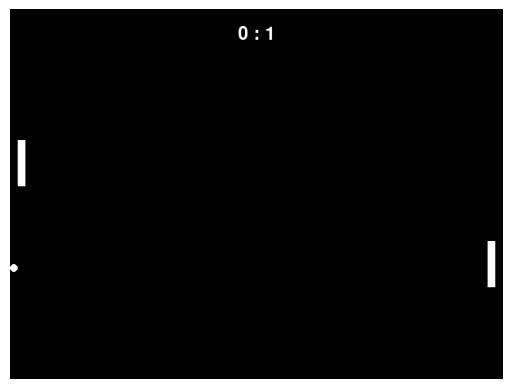

In [5]:
# Instantiate the environment with 'rgb_array' render mode
env = PongEnv(render_mode="rgb_array")

# Run a single episode and capture frames
frames, info = run_episode(env, max_steps=500, render=True)

# Display the frames as a GIF
display_frames_as_gif(frames, fps=30)

# Print the final scores
print(f"Final Score: Player 1 - {info['score1']}, Player 2 - {info['score2']}")

# Close the environment
env.close()
